In [3]:
# Disable scientific Python notation
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

# Create a Snowpark Session

In [4]:
# Snowflake Imports
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F

# Other imports
import json
import re

# Reading Snowflake Connection Details
snowflake_connection_cfg = json.loads(open('snowflake_connection.json').read())

# Creating Snowpark Session
session = Session.builder.configs(snowflake_connection_cfg).create()

# Switch Schema
session.use_schema('PYCON_DEMO._0_RAW')

# Data Engineering

In [5]:
# Create DataFrame
snowpark_df = session.table('ECOMMERCE_CUSTOMERS_100M')

# Get numeric columns
numerical_types = ['double','integer']
numeric_columns = [col[0] for col in snowpark_df.dtypes if col[1] in numerical_types]

# Get categorical columns
categorical_types = ['string']
categorical_columns = [col[0] for col in snowpark_df.dtypes if col[1] in categorical_types]

# Imputing missing values in numeric columns
for column in numeric_columns:
    snowpark_df = snowpark_df.fillna(snowpark_df[[F.mean(column)]].collect()[0][0], column)
    
# Impute missing values in categorical columns
for column in categorical_columns:
    snowpark_df = snowpark_df.fillna(snowpark_df[[F.mode(column)]].collect()[0][0], column)
    
# Split data into train & test
train_df, test_df = snowpark_df.random_split(weights=[0.7,0.3])

## SnowML Transformers

In [6]:
from snowflake.ml.framework.pipeline import Pipeline
from snowflake.ml.preprocessing import OneHotEncoder, MinMaxScaler
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.xgboost import XGBRegressor

import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

# Prepare data
preprocessing_pipeline = Pipeline(
    steps=[
    ('OHE',OneHotEncoder(input_cols=['GENDER','MEMBERSHIP_STATUS'], output_cols=['GENDER','MEMBERSHIP_STATUS'])),
    ('MMS',MinMaxScaler(input_cols=numeric_columns, output_cols=numeric_columns))
    ]
)
preprocessing_pipeline.fit(train_df)
train_df = preprocessing_pipeline.transform(train_df)
train_df = train_df.to_df([re.sub('[^0-9a-zA-Z_]+', '', col) for col in train_df.columns])
train_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"GENDER_FEMALE"  |"GENDER_MALE"  |"MEMBERSHIP_STATUS_BASIC"  |"MEMBERSHIP_STATUS_BRONZE"  |"MEMBERSHIP_STATUS_DIAMOND"  |"MEMBERSHIP_STATUS_GOLD"  |"MEMBERSHIP_STATUS_PLATIN"  |"MEMBERSHIP_STATUS_SILVER"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"        |"TIME_ON_WEBSITE"    |"YEARLY_SPENT"       |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## SnowML Model Training & Evaluation

In [7]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[10, 20],
        "learning_rate":[0.1, 0.2]
    },
    n_jobs=-1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=train_df.drop('EMAIL','GENDER','MEMBERSHIP_STATUS','YEARLY_SPENT').columns,
    label_cols='YEARLY_SPENT',
    output_cols='YEARLY_SPENT_PREDICTED'
)

grid_search.fit(train_df.limit(100000))

   YEARLY_SPENT  YEARLY_SPENT_PREDICTED
0        0.0030                  0.0841
1        0.8661                  0.7977
2        0.8120                  0.7963
3        0.4996                  0.5789
4        0.5546                  0.5794
Mean absolute percentage error: 0.8410466216488718


[Row(status='Statement executed successfully.')]

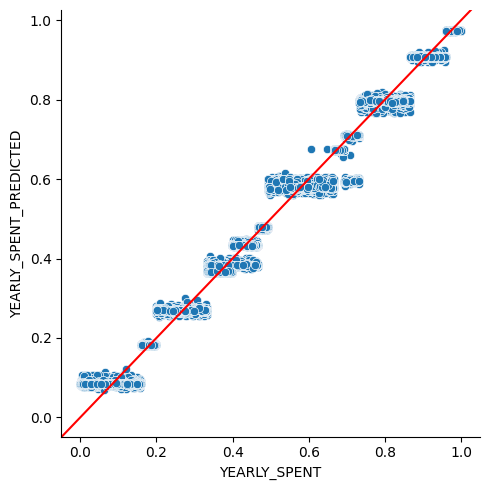

In [8]:
session.sql('ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE=XXLARGE WAIT_FOR_COMPLETION=TRUE').collect()

# Evaluate model
test_df = preprocessing_pipeline.transform(test_df)
test_df = test_df.to_df([re.sub('[^0-9a-zA-Z_]+', '', col) for col in test_df.columns])

result = grid_search.predict(test_df.limit(100000))

# Analyze results
df = result["YEARLY_SPENT", "YEARLY_SPENT_PREDICTED"].to_pandas().astype("float64")

print(df.head())
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(df['YEARLY_SPENT'],df['YEARLY_SPENT_PREDICTED'])}")
g = sns.relplot(data=df, x="YEARLY_SPENT", y="YEARLY_SPENT_PREDICTED", kind="scatter")
g.ax.axline((0,0), slope=1, color="r") 

session.sql('ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE=XSMALL WAIT_FOR_COMPLETION=TRUE').collect()